In [1]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime, timedelta
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
import seaborn
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

/home/junghwan/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# 개요
> 동적 자산 배분 전략인 DAA(Defensive Asset Allocation) 전략을 구현합니다.

DAA 전략은 폭락 신호를 미리 주는 카나리아 자산군을 이용하여 VAA 전략을 개선한 전략입니다. VAA와 비슷한 수준으로 하락 폭을 낮추면서 방어 자산에 머무르는 시간은 줄여보려는 시도를 합니다.

VAA 논문에 따르면 1970년부터 백테스트할 경우 60%의 기간에서 방어 자산에 머무르나, 방어 자산은 단기 혹은 중기 채권이니 하락 폭이 낮은 것이 어쩌면 당연합니다. 금리가 낮아져서 더 내려갈 곳이 없어 보이니 방어 자산인 채권 쪽에 머무는 기간이 짧을 수록 좋을 것이기 때문에 이러한 결과가 나온 것으로 보고, DAA 전략은 카나리아 자산군을 가지고 그 시도를 합니다.

--------------------------------------------------------------------------------

# 논문 실험

DAA 논문의 저자는 공격 자산으로 SPY (S&P 500), IWM (Russell 2000), QQQ (NASDAQ 100), VGK (Europe), EWJ (Japan), VWO (Emerging), VNQ (US REITs), GSG (Commodities), GLD (Gold), TLT (US 20+ Year Treasury), HYG (High Yield), LQD (Investment Grade Corporate Bond)를 사용합니다. 방어 자산으로 SHY (US 1-3 Year Treasury), IEF (US 7-10 Year Treasury), UST (Leveraged US 7-10 Year Treasury)를 사용합니다. 카나리아로는 VWO (Emerging), BND (US Bond)를 사용합니다.

방어 자산에서 레버리지 채권을 사용한다는 것과 카나리아의 작동 원리에 대한 명확한 설명이 없는 것이 상당히 마음에 걸리고 과최적화 요소가 있다는 생각이 듭니다. VAA는 그래도 직접 사용하려면 할 수도 있다는 생각이 들었는데, DAA는 과최적화 문제와 설명되지 않는 전략의 원리 때문에 전략의 성과가 괜찮을 경우 카나리아의 경고 기능만 참고하는 것이 더 나을 것 같습니다.

논문에서 제시하는 카나리아의 효과는 다음 그림과 같습니다. 카나리아 2개 모두가 음수 모멘텀이 되면 다음 달 S&P 500 수익률이 연 환산 기준 -14%이고, 그 때에도 S&P 500이 수익을 낼 가능성이 50%에 가까우니 카나리아가 모두 음수 모멘텀이라는 것은 큰 손실을 예견한다고 할 수 있습니다. 90년이 넘는 기간 동안의 결과이니 아주 말이 안 되는 것은 아니지만, 개인적으로는 VAA보다 가정이 많아 우월한 전략이라는 생각은 들지 않습니다.

![](https://user-images.githubusercontent.com/54884755/121810306-46843a00-cc9b-11eb-947f-ee2732d17140.jpg)

논문에서는 보유 자산의 개수와 유니버스의 구성에 따라 여러가지 버전을 소개하고 있지만, 가장 간단하게 구현하기 위해서 12개 자산 중 2개를 보유하고, 카나리아 중 1개라도 모멘텀이 음수가 되면 방어 자산으로 전환하는 것으로 하겠습니다.

## 매수 매도 규칙
1. 공격 자산, 방어 자산의 모멘텀 점수를 계산
2. 카나리아 자산군의 모멘텀 점수가 모두 (+)인 경우 공격 자산 중 모멘텀 점수가 가장 높은 2개 자산 보유
3. 카나리아 자산군 중 하나라도 모멘텀 점수가 (-)인 경우 수비 자산 중 모멘텀 점수가 가장 높은 자산을 보유
4. 월별 리밸런싱

In [2]:
# 공격 자산 : ['SPY','IWM','QQQ','VGK','EWJ','VNQ','GSG','GLD','TLT','HYG','LQD']
# 방어 자산 : ['SHY','IEF','UST']
# 카나리아 자산 : ['VWO', 'BND']
# UST starts: 2010-02-02

start = datetime(2010,2,2)
end = datetime(2021,5,31)

tickers = ['SPY','IWM','QQQ','VGK','EWJ','VWO','VNQ','GSG','GLD','TLT','HYG','LQD','SHY','IEF','UST','BND']

def get_price_data(tickers):
    df_asset = pd.DataFrame(columns=tickers)
    
    for ticker in tickers:
        df_asset[ticker] = pdr.get_data_yahoo(ticker, start, end)['Adj Close']  
         
    return df_asset

In [3]:
df_asset = get_price_data(tickers)
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,HYG,LQD,SHY,IEF,UST,BND
Date,,,,,,,,,,,,,,,,
2010-02-01,86.234505,51.427647,38.507648,30.428082,32.782578,28.874586,26.765957,29.760000,108.349998,66.188026,42.706692,68.397499,75.445854,71.319290,NaN,56.403194
2010-02-02,87.278229,51.994186,38.854820,30.898417,33.409210,29.014040,27.132874,30.540001,109.129997,66.376831,42.835815,68.613426,75.454872,71.438057,31.798569,56.438751
2010-02-03,86.843376,51.647511,39.068451,30.512999,33.079399,28.933311,26.691330,30.430000,108.699997,65.607056,43.054386,68.541451,75.400627,71.097656,31.498888,56.403194
2010-02-04,84.162857,49.922523,37.937981,29.017075,32.452778,27.612152,25.702541,29.180000,104.370003,66.645447,42.443428,68.534874,75.509048,71.683495,31.990906,56.509857
2010-02-05,84.336815,50.117008,38.258427,28.749250,32.386810,27.560780,26.175161,28.610001,104.680000,66.790710,42.195084,68.325516,75.626526,71.913040,32.201145,56.602322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,413.725616,219.301651,330.924622,66.755463,66.851646,51.151451,96.356049,15.320000,176.350006,135.978516,83.666916,128.551666,86.027870,113.185837,66.851288,83.373192
2021-05-25,412.807648,217.181946,331.382446,66.784592,66.694870,51.686714,96.326874,15.230000,177.949997,137.238144,83.676506,129.030396,86.027870,113.601669,67.390579,83.588486
2021-05-26,413.626892,221.233185,332.536926,66.590370,66.841843,52.066261,96.754700,15.260000,177.639999,137.001938,83.705299,128.961990,86.047806,113.472961,67.230782,83.559135


## 자산 별 모멘텀 계산

모멘텀은 VAA와 같은 방식으로 측정합니다.

```python
momentum = (x/before_1m - 1) * 12 + (x/before_3m - 1) * 4 + (x/before_6m - 1) * 2 + (x/before_12m - 1) * 1
```
위의 모멘텀 계산식에서 알 수 있듯이 1개월 전일 경우 12의 가중치를, 3개월 전일 경우 4의 가중치를, 6개월 전일 경우 2의 가중치를, 12개월 전일 경우 1의 가중치를 주는 방식으로 한마디로 **'최근일수록 가중치를 크게 부여'**하는 방식입니다.

In [4]:
def get_momentum(x):
    temp = [0 for _ in range(len(x.index))]
    momentum = pd.Series(temp, index=x.index)
    
    try:
        before_1m = df_asset[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1]
        before_3m = df_asset[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1]
        before_6m = df_asset[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1]
        before_12m = df_asset[x.name-timedelta(days=370):x.name-timedelta(days=365)].iloc[-1]
        momentum = (x/before_1m - 1) * 12 + (x/before_3m - 1) * 4 + (x/before_6m - 1) * 2 + (x/before_12m - 1) * 1
        
    except:
        pass
    
    return momentum

In [5]:
momentum_col = [col + '_m' for col in df_asset.columns]
df_asset[momentum_col] = df_asset.apply(lambda x: get_momentum(x), axis=1)
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,VNQ_m,GSG_m,GLD_m,TLT_m,HYG_m,LQD_m,SHY_m,IEF_m,UST_m,BND_m
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,86.234505,51.427647,38.507648,30.428082,32.782578,28.874586,26.765957,29.760000,108.349998,66.188026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-02,87.278229,51.994186,38.854820,30.898417,33.409210,29.014040,27.132874,30.540001,109.129997,66.376831,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-03,86.843376,51.647511,39.068451,30.512999,33.079399,28.933311,26.691330,30.430000,108.699997,65.607056,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-04,84.162857,49.922523,37.937981,29.017075,32.452778,27.612152,25.702541,29.180000,104.370003,66.645447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-05,84.336815,50.117008,38.258427,28.749250,32.386810,27.560780,26.175161,28.610001,104.680000,66.790710,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,413.725616,219.301651,330.924622,66.755463,66.851646,51.151451,96.356049,15.320000,176.350006,135.978516,...,1.358084,1.935591,1.049765,-0.628454,0.241144,-0.017865,0.009606,-0.220735,-0.475887,-0.083241
2021-05-25,412.807648,217.181946,331.382446,66.784592,66.694870,51.686714,96.326874,15.230000,177.949997,137.238144,...,1.318387,1.754967,1.234661,-0.432183,0.239205,0.046774,0.010533,-0.146307,-0.316345,-0.032068
2021-05-26,413.626892,221.233185,332.536926,66.590370,66.841843,52.066261,96.754700,15.260000,177.639999,137.001938,...,1.418437,1.703291,1.283438,-0.386544,0.278159,0.101122,0.023759,-0.104925,-0.248059,0.001231


12개월 모멘텀을 사용하였기 때문에 앞의 1년은 사용하지 못합니다.
그렇기 때문에 이를 제거하고 2011년 2월부터를 확인하겠습니다.

In [6]:
df_asset = df_asset.loc[df_asset.index >= '2004-10-01']
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,VNQ_m,GSG_m,GLD_m,TLT_m,HYG_m,LQD_m,SHY_m,IEF_m,UST_m,BND_m
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,86.234505,51.427647,38.507648,30.428082,32.782578,28.874586,26.765957,29.760000,108.349998,66.188026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-02,87.278229,51.994186,38.854820,30.898417,33.409210,29.014040,27.132874,30.540001,109.129997,66.376831,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-03,86.843376,51.647511,39.068451,30.512999,33.079399,28.933311,26.691330,30.430000,108.699997,65.607056,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-04,84.162857,49.922523,37.937981,29.017075,32.452778,27.612152,25.702541,29.180000,104.370003,66.645447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-05,84.336815,50.117008,38.258427,28.749250,32.386810,27.560780,26.175161,28.610001,104.680000,66.790710,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,413.725616,219.301651,330.924622,66.755463,66.851646,51.151451,96.356049,15.320000,176.350006,135.978516,...,1.358084,1.935591,1.049765,-0.628454,0.241144,-0.017865,0.009606,-0.220735,-0.475887,-0.083241
2021-05-25,412.807648,217.181946,331.382446,66.784592,66.694870,51.686714,96.326874,15.230000,177.949997,137.238144,...,1.318387,1.754967,1.234661,-0.432183,0.239205,0.046774,0.010533,-0.146307,-0.316345,-0.032068
2021-05-26,413.626892,221.233185,332.536926,66.590370,66.841843,52.066261,96.754700,15.260000,177.639999,137.001938,...,1.418437,1.703291,1.283438,-0.386544,0.278159,0.101122,0.023759,-0.104925,-0.248059,0.001231


월 말 리밸런싱을 할 것이니 월말 데이터만 남깁니다.

In [7]:
df_asset = df_asset.resample(rule='M').last()
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,VNQ_m,GSG_m,GLD_m,TLT_m,HYG_m,LQD_m,SHY_m,IEF_m,UST_m,BND_m
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,87.562897,53.101868,39.842880,29.520073,32.782578,28.595688,27.754755,30.969999,109.430000,66.565598,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-03-31,92.893684,57.472538,42.915157,31.440607,34.431595,30.937071,30.582073,31.160000,108.949997,65.196106,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-04-30,94.330750,60.736092,43.877529,30.245163,34.266705,30.871014,32.768730,32.139999,115.360001,67.361786,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-05-31,86.835754,56.158627,40.633923,26.691523,31.364410,28.037859,31.020645,27.770000,118.879997,70.802872,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-06-30,82.342789,51.810043,38.205776,26.253851,30.560764,27.883734,29.403765,27.790001,121.680000,74.907928,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,364.070892,203.229584,312.665283,57.727886,65.636681,50.230274,82.127380,12.910000,172.610001,148.803574,...,0.697270,1.933817,-0.400905,-0.692182,0.292506,-0.084926,0.031092,-0.165832,-0.372042,-0.039654
2021-02-28,374.194061,215.835037,312.247864,59.217010,66.841843,51.017551,84.940369,14.240000,161.809998,140.272736,...,0.743282,2.643653,-1.081718,-1.489640,0.164810,-0.427829,0.016122,-0.560362,-1.158782,-0.296831
2021-03-31,391.182220,218.846024,317.608398,61.181171,67.135773,50.655117,89.316513,13.970000,159.960007,132.915085,...,1.573882,1.617859,-0.656969,-1.527837,0.344304,-0.377560,-0.008303,-0.702036,-1.381369,-0.324972


## 자산 매수 / 월별 리밸런싱

공격 자산 중 모멘텀이 가장 좋은 2개를 고릅니다. 카나리아 자산 중 1개라도 모멘텀이 음수면 방어 자산 중 모멘텀이 가장 좋은 자산으로 갑니다.

In [8]:
def select_asset(x):
    selected_asset = pd.Series([0,0,0,0], index=['ASSET1','PRICE1','ASSET2','PRICE2'])
    momentum1 = None
    momentum2 = None
    
    # 모든 카나라아 자산 > 0
    if x['VWO_m'] > 0 and x['BND_m'] > 0:
        # momentum_col = [col + '_m' for col in df_asset.columns]
        selected_momentum = x[momentum_col].sort_values(ascending=False)
        momentum1 = selected_momentum[0]
        momentum2 = selected_momentum[1]
        
        selected_asset['ASSET1'] = x[x==momentum1].index[0][:3]
        selected_asset['PRICE1'] = x[selected_asset['ASSET1']]
        selected_asset['ASSET2'] = x[x==momentum2].index[0][:3]
        selected_asset['PRICE2'] = x[selected_asset['ASSET2']]

    # 카나리아 자산 중 1개라도 < 0
    else:
        selected_momentum = max(x['SHY_m'], x['IEF_m'], x['UST_m'])
    
        # 이 경우 ASSET1, ASSET2는 같음
        selected_asset['ASSET1'] = x[x==selected_momentum].index[0][:3]
        selected_asset['PRICE1'] = x[selected_asset['ASSET1']]
        selected_asset['ASSET2'] = x[x==selected_momentum].index[0][:3]
        selected_asset['PRICE2'] = x[selected_asset['ASSET2']]
    
    return selected_asset

In [9]:
df_asset[['ASSET1','PRICE1','ASSET2','PRICE2']] = df_asset.apply(lambda x: select_asset(x), axis=1) 
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,HYG_m,LQD_m,SHY_m,IEF_m,UST_m,BND_m,ASSET1,PRICE1,ASSET2,PRICE2
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,87.562897,53.101868,39.842880,29.520073,32.782578,28.595688,27.754755,30.969999,109.430000,66.565598,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,SPY,87.562897,SPY,87.562897
2010-03-31,92.893684,57.472538,42.915157,31.440607,34.431595,30.937071,30.582073,31.160000,108.949997,65.196106,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,SPY,92.893684,SPY,92.893684
2010-04-30,94.330750,60.736092,43.877529,30.245163,34.266705,30.871014,32.768730,32.139999,115.360001,67.361786,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,SPY,94.330750,SPY,94.330750
2010-05-31,86.835754,56.158627,40.633923,26.691523,31.364410,28.037859,31.020645,27.770000,118.879997,70.802872,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,SPY,86.835754,SPY,86.835754
2010-06-30,82.342789,51.810043,38.205776,26.253851,30.560764,27.883734,29.403765,27.790001,121.680000,74.907928,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,SPY,82.342789,SPY,82.342789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,364.070892,203.229584,312.665283,57.727886,65.636681,50.230274,82.127380,12.910000,172.610001,148.803574,...,0.292506,-0.084926,0.031092,-0.165832,-0.372042,-0.039654,SHY,86.044777,SHY,86.044777
2021-02-28,374.194061,215.835037,312.247864,59.217010,66.841843,51.017551,84.940369,14.240000,161.809998,140.272736,...,0.164810,-0.427829,0.016122,-0.560362,-1.158782,-0.296831,SHY,85.994957,SHY,85.994957
2021-03-31,391.182220,218.846024,317.608398,61.181171,67.135773,50.655117,89.316513,13.970000,159.960007,132.915085,...,0.344304,-0.377560,-0.008303,-0.702036,-1.381369,-0.324972,SHY,85.947151,SHY,85.947151


In [10]:
return_col = [ticker + '_r' for ticker in tickers]
df_asset[return_col] = df_asset[tickers].pct_change()
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,VNQ_r,GSG_r,GLD_r,TLT_r,HYG_r,LQD_r,SHY_r,IEF_r,UST_r,BND_r
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,87.562897,53.101868,39.842880,29.520073,32.782578,28.595688,27.754755,30.969999,109.430000,66.565598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-31,92.893684,57.472538,42.915157,31.440607,34.431595,30.937071,30.582073,31.160000,108.949997,65.196106,...,0.101868,0.006135,-0.004386,-0.020574,0.021335,0.006518,-0.002692,-0.010569,-0.022389,-0.002218
2010-04-30,94.330750,60.736092,43.877529,30.245163,34.266705,30.871014,32.768730,32.139999,115.360001,67.361786,...,0.071501,0.031451,0.058834,0.033218,0.019244,0.019078,0.003002,0.016529,0.032575,0.010702
2010-05-31,86.835754,56.158627,40.633923,26.691523,31.364410,28.037859,31.020645,27.770000,118.879997,70.802872,...,-0.053346,-0.135968,0.030513,0.051084,-0.046755,-0.013082,0.004529,0.029332,0.055104,0.011274
2010-06-30,82.342789,51.810043,38.205776,26.253851,30.560764,27.883734,29.403765,27.790001,121.680000,74.907928,...,-0.052123,0.000720,0.023553,0.057979,0.011112,0.032785,0.004190,0.030483,0.059016,0.014511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,364.070892,203.229584,312.665283,57.727886,65.636681,50.230274,82.127380,12.910000,172.610001,148.803574,...,0.000353,0.047040,-0.032238,-0.036328,-0.003780,-0.018316,0.000232,-0.010921,-0.022262,-0.008618
2021-02-28,374.194061,215.835037,312.247864,59.217010,66.841843,51.017551,84.940369,14.240000,161.809998,140.272736,...,0.034252,0.103021,-0.062569,-0.057330,-0.002447,-0.022633,-0.000579,-0.023633,-0.047341,-0.015477
2021-03-31,391.182220,218.846024,317.608398,61.181171,67.135773,50.655117,89.316513,13.970000,159.960007,132.915085,...,0.051520,-0.018961,-0.011433,-0.052452,0.012156,-0.014780,-0.000556,-0.023857,-0.047368,-0.012714


## 성과 확인

전략의 월별 수익률을 계산합니다. 이에 대한 요약은 아래와 같습니다.
- 136 개월 중 수익 월 : 91 개월
- 136 개월 중 손실 월 : 45 개월
- 승률 : 66.91
- CAGR :  12.5
- MDD :  -12.71
- STDEV : 10.81
- Return-Risk Ratio:  1.16

이 전략도 VAA 전략만큼이나 수익률도 괜찮고 MDD도 낮으며 연 변동성도 낮습니다. 다만 앞서 언급한대로 과최적화 가능성과 카나리아 동작 원리에 대한 명확한 규명이 없어 실전에서 사용할때는 **가정이 비교적 적고 논리적으로 단순한 VAA**가 부담이 덜할 것으로 예상됩니다.

In [11]:
df_asset['RETURN'] = 0
df_asset['RETURN_ACC'] = 0
df_asset['LOG_RETURN'] = 0
df_asset['LOG_RETURN_ACC'] = 0

for i in range(len(df_asset)):
    strat_return = 0
    log_strat_return = 0
    
    # 직전 달 모멘텀이 좋은 것으로 리밸런싱해서 앞으로 한 달 가져가는 것
    if i > 0:
        strat_return = (df_asset[df_asset.iloc[i-1]['ASSET1']+'_r'].iloc[i]+df_asset[df_asset.iloc[i-1]['ASSET2']+'_r'].iloc[i])/2
        log_strat_return = math.log(strat_return + 1)
        
    df_asset.loc[df_asset.index[i], 'RETURN'] = strat_return
    # 누적 = 직전 누적 * 현재
    df_asset.loc[df_asset.index[i], 'RETURN_ACC'] = (1+df_asset.loc[df_asset.index[i-1], 'RETURN_ACC'])*(1+strat_return)-1
    df_asset.loc[df_asset.index[i], 'LOG_RETURN'] = log_strat_return
    # 로그누적 = 직전 로그누적 + 현재 로그
    df_asset.loc[df_asset.index[i], 'LOG_RETURN_ACC'] = df_asset.loc[df_asset.index[i-1], 'LOG_RETURN_ACC'] + log_strat_return
    
# 수익률 * 100
df_asset[['RETURN','RETURN_ACC','LOG_RETURN','LOG_RETURN_ACC']] = df_asset[['RETURN','RETURN_ACC','LOG_RETURN','LOG_RETURN_ACC']]*100
df_asset[return_col] = df_asset[return_col] * 100
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,HYG_r,LQD_r,SHY_r,IEF_r,UST_r,BND_r,RETURN,RETURN_ACC,LOG_RETURN,LOG_RETURN_ACC
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,87.562897,53.101868,39.842880,29.520073,32.782578,28.595688,27.754755,30.969999,109.430000,66.565598,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
2010-03-31,92.893684,57.472538,42.915157,31.440607,34.431595,30.937071,30.582073,31.160000,108.949997,65.196106,...,2.133531,0.651834,-0.269201,-1.056862,-2.238922,-0.221807,6.087953,6.087953,5.909831,5.909831
2010-04-30,94.330750,60.736092,43.877529,30.245163,34.266705,30.871014,32.768730,32.139999,115.360001,67.361786,...,1.924432,1.907778,0.300183,1.652851,3.257459,1.070231,1.547000,7.729133,1.535156,7.444986
2010-05-31,86.835754,56.158627,40.633923,26.691523,31.364410,28.037859,31.020645,27.770000,118.879997,70.802872,...,-4.675521,-1.308206,0.452887,2.933158,5.510374,1.127426,-7.945442,-0.830423,-8.278876,-0.833890
2010-06-30,82.342789,51.810043,38.205776,26.253851,30.560764,27.883734,29.403765,27.790001,121.680000,74.907928,...,1.111163,3.278525,0.419038,3.048276,5.901600,1.451145,-5.174096,-5.961552,-5.312757,-6.146647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,364.070892,203.229584,312.665283,57.727886,65.636681,50.230274,82.127380,12.910000,172.610001,148.803574,...,-0.377989,-1.831573,0.023157,-1.092116,-2.226151,-0.861771,2.553402,279.887251,2.521348,133.470431
2021-02-28,374.194061,215.835037,312.247864,59.217010,66.841843,51.017551,84.940369,14.240000,161.809998,140.272736,...,-0.244675,-2.263295,-0.057900,-2.363319,-4.734134,-1.547705,-0.057900,279.667296,-0.057917,133.412515
2021-03-31,391.182220,218.846024,317.608398,61.181171,67.135773,50.655117,89.316513,13.970000,159.960007,132.915085,...,1.215554,-1.478041,-0.055591,-2.385697,-4.736801,-1.271401,-0.055591,279.456233,-0.055607,133.356908


In [12]:
# MDD

df_asset['BALANCE'] = (1+df_asset['RETURN']/100).cumprod()
df_asset['DRAWDOWN'] = -(df_asset['BALANCE'].cummax() - df_asset['BALANCE']) / df_asset['BALANCE'].cummax()

df_asset[['BALANCE','DRAWDOWN']] = df_asset[['BALANCE','DRAWDOWN']] * 100
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,SHY_r,IEF_r,UST_r,BND_r,RETURN,RETURN_ACC,LOG_RETURN,LOG_RETURN_ACC,BALANCE,DRAWDOWN
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,87.562897,53.101868,39.842880,29.520073,32.782578,28.595688,27.754755,30.969999,109.430000,66.565598,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,100.000000,-0.000000
2010-03-31,92.893684,57.472538,42.915157,31.440607,34.431595,30.937071,30.582073,31.160000,108.949997,65.196106,...,-0.269201,-1.056862,-2.238922,-0.221807,6.087953,6.087953,5.909831,5.909831,106.087953,-0.000000
2010-04-30,94.330750,60.736092,43.877529,30.245163,34.266705,30.871014,32.768730,32.139999,115.360001,67.361786,...,0.300183,1.652851,3.257459,1.070231,1.547000,7.729133,1.535156,7.444986,107.729133,-0.000000
2010-05-31,86.835754,56.158627,40.633923,26.691523,31.364410,28.037859,31.020645,27.770000,118.879997,70.802872,...,0.452887,2.933158,5.510374,1.127426,-7.945442,-0.830423,-8.278876,-0.833890,99.169577,-7.945442
2010-06-30,82.342789,51.810043,38.205776,26.253851,30.560764,27.883734,29.403765,27.790001,121.680000,74.907928,...,0.419038,3.048276,5.901600,1.451145,-5.174096,-5.961552,-5.312757,-6.146647,94.038448,-12.708434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,364.070892,203.229584,312.665283,57.727886,65.636681,50.230274,82.127380,12.910000,172.610001,148.803574,...,0.023157,-1.092116,-2.226151,-0.861771,2.553402,279.887251,2.521348,133.470431,379.887251,-0.000000
2021-02-28,374.194061,215.835037,312.247864,59.217010,66.841843,51.017551,84.940369,14.240000,161.809998,140.272736,...,-0.057900,-2.363319,-4.734134,-1.547705,-0.057900,279.667296,-0.057917,133.412515,379.667296,-0.057900
2021-03-31,391.182220,218.846024,317.608398,61.181171,67.135773,50.655117,89.316513,13.970000,159.960007,132.915085,...,-0.055591,-2.385697,-4.736801,-1.271401,-0.055591,279.456233,-0.055607,133.356908,379.456233,-0.113459


In [13]:
total_month = len(df_asset)
profit_month = len(df_asset[df_asset['RETURN'] >= 0])
loss_month = len(df_asset[df_asset['RETURN'] < 0])
win_rate = profit_month / total_month * 100
CAGR = ((1+df_asset['RETURN_ACC'][-1]/100)**(1/(total_month/12)))-1
STDEV = np.std(df_asset['RETURN'][1:])*math.sqrt(12)
RRR = CAGR * 100 / STDEV

print(total_month, "개월 중 수익 월 :", profit_month, "개월")
print(total_month, "개월 중 손실 월 :", loss_month, "개월")
print("승률 :", round(win_rate, 2))

print('CAGR : ', round(CAGR*100, 2))
print('MDD : ', round(df_asset['DRAWDOWN'].min(), 2))
print('STDEV :', round(STDEV, 2))
print('Return-Risk Ratio: ', round(RRR, 2))

136 개월 중 수익 월 : 91 개월
136 개월 중 손실 월 : 45 개월
승률 : 66.91
CAGR :  12.5
MDD :  -12.71
STDEV : 10.81
Return-Risk Ratio:  1.16


<AxesSubplot:xlabel='Date', ylabel='LOG_RETURN_ACC'>

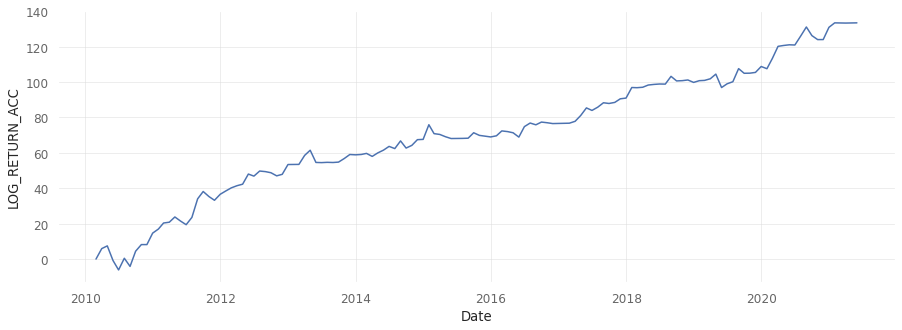

In [14]:
plt.figure(figsize=(15,5))
seaborn.lineplot(data=df_asset, x=df_asset.index, y=df_asset['LOG_RETURN_ACC'])

<AxesSubplot:xlabel='Date', ylabel='DRAWDOWN'>

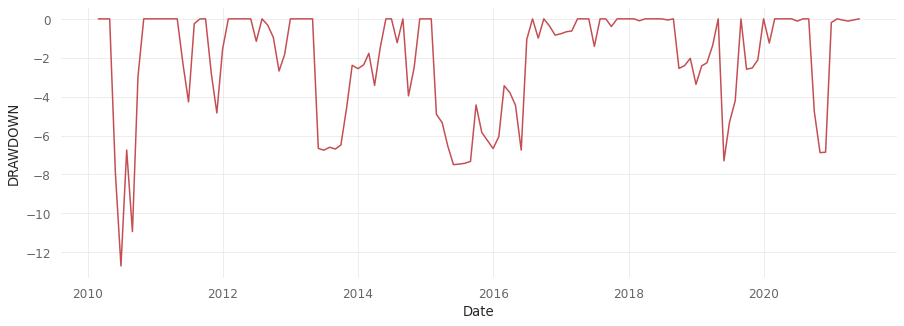

In [15]:
plt.figure(figsize=(15,5))
seaborn.lineplot(data=df_asset, x=df_asset.index, y=df_asset['DRAWDOWN'], color='r')

In [16]:
quantstats.stats.sharpe(df_asset['RETURN'])/math.sqrt(252/12)

1.1469562584369202

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


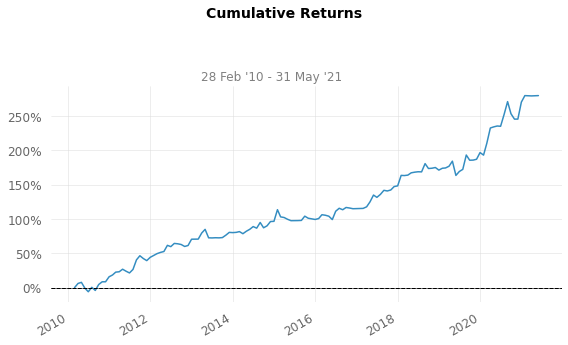

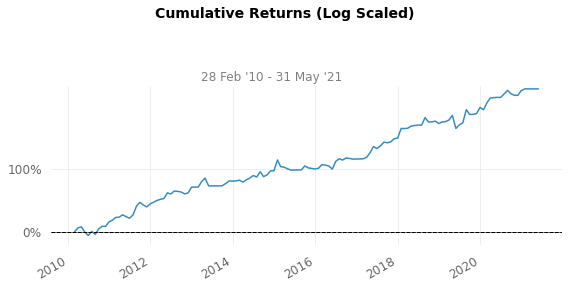

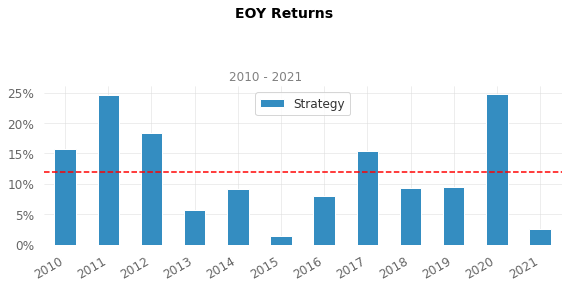

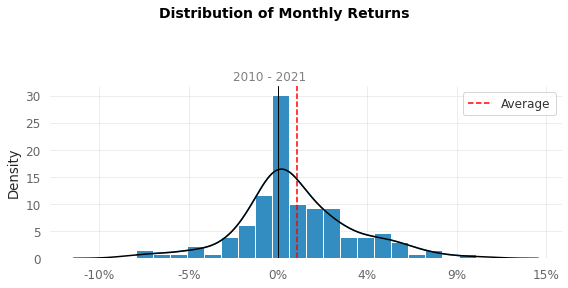

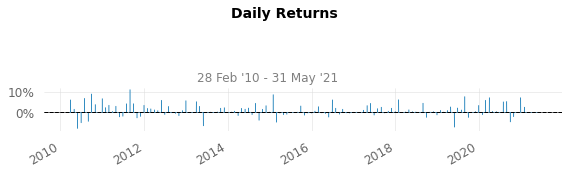

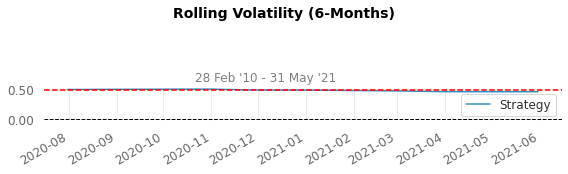

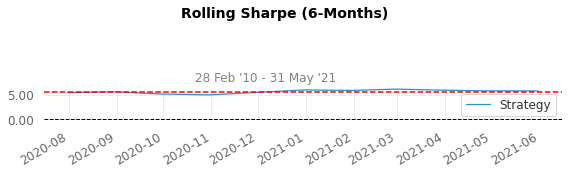

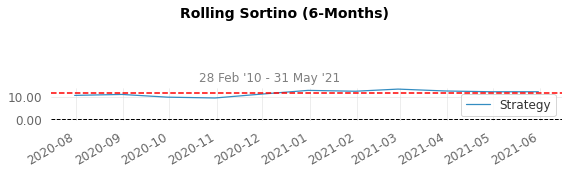

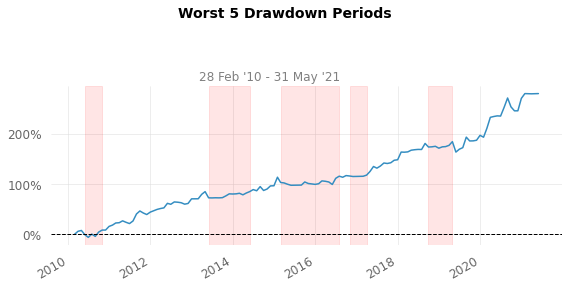

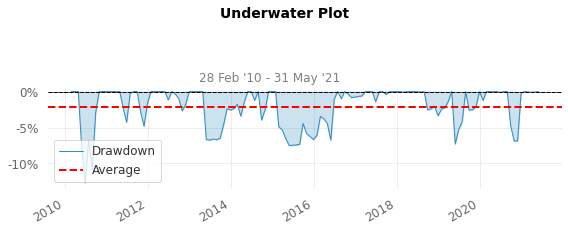

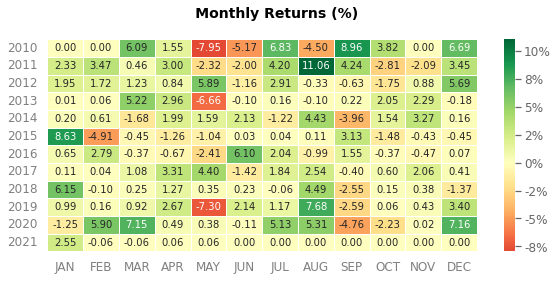

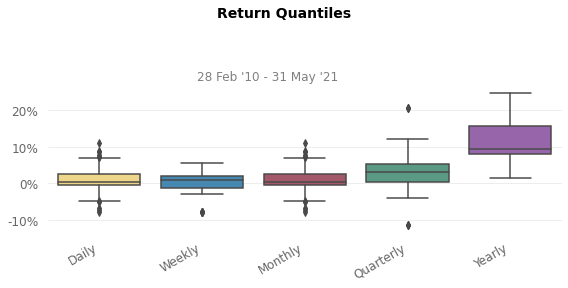

In [17]:
quantstats.reports.plots(df_asset['RETURN']/100, mode='full')

In [18]:
quantstats.reports.html(df_asset['RETURN']/100, 'SPY')